## Bayesian Cut Introduction
### BC vs dcSBM

Load the package

In [2]:
from bayesian_cut.data.load import load_data
from bayesian_cut.cuts.bayesian_models import Model

Load an example network

In [3]:
network_name = 'karate'
X, Y = load_data(network=network_name, labels=True, remove_disconnected=True)

/home/lauve/miniconda3/envs/bayesian_cut/lib/python3.6/site-packages/scipy/sparse/compressed.py:708: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self[i, j] = values


Set the model parameters

In [4]:
n_samples_per_chain = 75
n_chains = 15
C = 2

model_params = {
    'alpha_in': 1e-2,
    'beta_in': 1e-2,
    'alpha_out': 1e-2,
    'beta_out': 1e-2,
    'b': 1,
    'gamma': 3
}

Define the models

In [5]:
BC = Model('ShiftedApproximateBayesianCommunityDetection',
           X,
           model_params,
           Y=Y,
           C=C,
           block_sampling=False,
           marginalize_phi=True
          )
dcSBM = Model('BayesianStochasticBlockmodelSharedEtaOut',
           X,
           model_params,
           Y=Y,
           C=C,
           block_sampling=False,
           marginalize_phi=True
          )

Now let us add the number of chains for each model

In [6]:
BC.add_chains(number_of_chains=n_chains)
dcSBM.add_chains(number_of_chains=n_chains)

/home/lauve/Desktop/bayesian_cut/bayesian_cut/cuts/bayesian_models.py:144: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._X_blocks[:, self._sample_indices] = 0


Now we can run the chains for each model

In [7]:
BC.run_chains(n_samples=n_samples_per_chain,
        n_prior_updates=20,
        verbose=2,
        save_all_samples=False,
        parallel=True
    )

In [8]:
dcSBM.run_chains(n_samples=n_samples_per_chain,
        n_prior_updates=20,
        verbose=2,
        save_all_samples=False,
        parallel=True
    )

After finishing the sampler for both models, we can now plot the results

In [9]:
from bayesian_cut.utils import utils

Calling the function cluster_plot and giving the model with the sampled chains will automatically create the adjacency matrix by using the best sample obtained during sampling

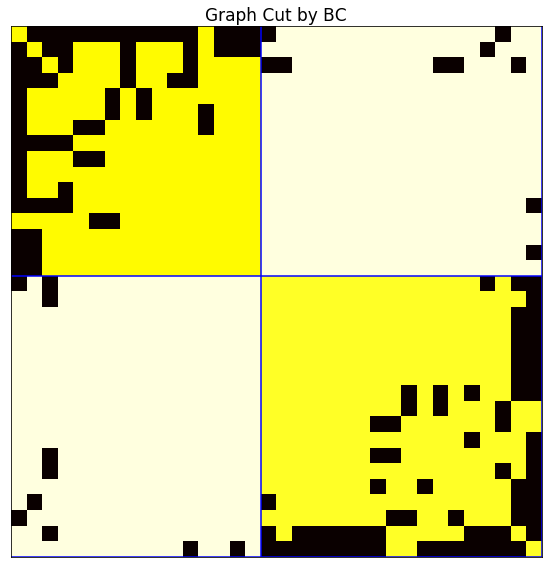

In [10]:
utils.cluster_plot(BC, title='Graph Cut by BC')

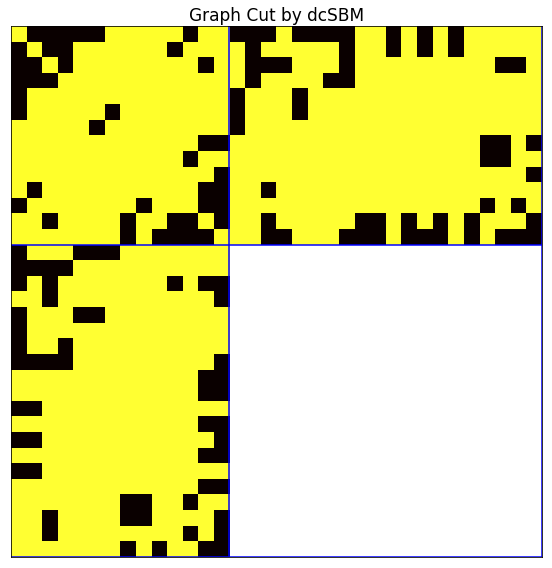

In [11]:
utils.cluster_plot(dcSBM, title='Graph Cut by dcSBM')

Looking at the optimal cut of each respective model, we clearly see that there is a strong discrepancy between the two models.
Therefore, we now take a look at the sampled solution spaces by each method to show the differences of the models.

First we aggregate all samples to create a combined posterior landscape

In [12]:
# Aggregate all samples
import numpy as np
z_matrix = None
z_matrix, _, _, _ = BC.aggregate_chain_samples(with_burn_in=True)
z_agg, _, _, _ = dcSBM.aggregate_chain_samples(with_burn_in=True)
z_matrix = np.vstack((z_matrix, z_agg))

unique_z_matrix = np.unique(z_matrix, return_index=False, axis=0)

new_z_matrix = utils.generate_new_samples_only(int(0.5 * unique_z_matrix.shape[0]), unique_z_matrix)

combined_z_matrix = np.vstack((new_z_matrix, unique_z_matrix))

combined_unique_z_matrix, indices = np.unique(combined_z_matrix, return_index=True, axis=0)

Followingly, the entire log probabilities have to be evaluated for all the samples and each model

In [13]:
unique_log_probs = {}

unique_log_probs['BC'] = utils.recalculate_prob_for_z(BC, combined_unique_z_matrix)
unique_log_probs['dcSBM'] = utils.recalculate_prob_for_z(dcSBM, combined_unique_z_matrix)

# Calculate the similarity matrix for it
sim_matrix = utils.calc_sim_matrix(combined_unique_z_matrix)

In [14]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

Now that we have calculated the log-likelihood landscape for both models using the joint posterior, we can
plot the landscape to analyze the solution space of each model.

In [ ]:
utils.landscape_plotting_notebook(sim_matrix, unique_log_probs['BC'], z_solutions=[BC.get_best_chain().max_log_lik_z_, dcSBM.get_best_chain().max_log_lik_z_],
                                  z_matrix=combined_unique_z_matrix, z_title='log-likelihood', title='Solution landscape')

The output of the plot is not contained in this notebook, because it will add approximately 40Mb to the size of the notebook.
Running this code will give an interactive plotly output, which looks like
![](https://github.com/DTUComputeCognitiveSystems/bayesian_cut/raw/master/examples/BC_landscape.png "BC_landscape")

![](BC_landscape.png "BC_landscape")

In [ ]:
utils.landscape_plotting_notebook(sim_matrix, unique_log_probs['dcSBM'], z_solutions=[BC.get_best_chain().max_log_lik_z_, dcSBM.get_best_chain().max_log_lik_z_],
                                  z_matrix=combined_unique_z_matrix, z_title='log-likelihood', title='Solution landscape')

The output of the plot is not contained in this notebook, because it will add approximately 40Mb to the size of the notebook.
Running this code will give an interactive plotly output, which looks like
![](https://github.com/DTUComputeCognitiveSystems/bayesian_cut/raw/master/examples/BC_landscape.png "BC_landscape")

![](dcSBM_landscape.png 'dcSBM_landscape')

Looking at those two plots, we can clearly see the impact the community constraint $b$ has on the solution landscape, which leads to a more reasonable cut.